# MarginGAN: Adversarial Training in Semi-Supervised Learning

**Authors:** Jinhao Dong, Tong Lin

PyTorch implementation of the NIPS 2019 paper "MarginGAN".

**Link:** https://papers.nips.cc/paper/9231-margingan-adversarial-training-in-semi-supervised-learning7

**Code Authors:** <br/>
Can Ufuk Ertenli - ufuk.ertenli@metu.edu.tr <br/>
Zeynep Sonat Baltacı - sonat.baltaci@metu.edu.tr

We start with a brief overview of MarginGAN: Adversarial Training in Semi-Supervised Learning. To this end, we first introduce the concepts of semi-supervised learning and margin.

### Semi-Supervised Learning
Semi-supervised learning (SSL) is a learning method that aims to train high accuracy classifiers utilizing only a limited amount of labeled data and large amounts of unlabeled data in the training process. This method is practical since labeled data is expensive, and unlabeled data is not hard to come by. In SSL, pseudo-label techniques are commonly used to assign labels to unlabeled data in order to incorporate unlabeled data to the training process to improve model robustness.
### Margin
Next, we give the definition of margin, directly from the paper: “The margin of a single data point is defined to be the distance from that data point to a decision boundary, which can be used to bound the generalization error of the classifier.” In the SSL setting, the goal is to train high accuracy classifiers. But, we also want to have large-margin classifiers so that our predictions will be robust. 

To understand the idea of large-margin classifiers, a four-class problem is illustrated in Fig. 1. If the classifier believes the wrong pseudo-label, the decision boundary will be updated to cover the gap between the two classes of examples, the margin between the decision boundaries decreases, which hurts the generalization accuracy. Therefore, large-margin classifiers should ignore those wrong pseudo-labels to achieve higher accuracy. To construct MarginGAN, it is crucial to understand the margin notion in terms of SSL and multi-class classification. 

<p><img src="https://raw.githubusercontent.com/sonatbaltaci/marginGAN/master/figures/marginGAN_fig2.png" height=300px></p>

Fig. 1: Four class toy example to illustrate the idea of large-margin classifiers [1]


In SSL, the margin of an unlabeled example is denoted as $|f(x)|$, which is also represented as $\tilde{y}f(x)$  where $\tilde{y} = \text{sign}(f(x))$ [2].With this definition, the current prediction is regarded as correct and makes the classifier confident of what is predicted. If we define the margin in multi-class classification, it is the difference between the probability for the true class, and the maximal probability for the false classes, 

$$
\text{Margin}(x,y) = C_{y}(x) - \max_{i \neq y}C_{i}(x)
$$

which is the evidence that if the margin is large, the probability of the correct class has peaked in the classification distribution.

### MarginGAN
MarginGAN is a semi-supervised learning model that utilizes a standard GAN architecture to improve the performance of a classifier by increasing the margin of real examples and decreasing the margin of generated examples in parallel.

In addition to a generator G and a discriminator D in a GAN architecture, there is also a classifier C in MarginGAN. With the addition of C, the standard two-player minimax game between G and D, now transforms into a three-player minimax game. The overall architecture of MarginGAN is provided in Fig. 2.

<p><img src="https://raw.githubusercontent.com/sonatbaltaci/marginGAN/master/figures/marginGAN_fig1.png" height=300px></p>

Fig. 2: Overall architecture of MarginGAN [1]

#### Discriminator

D’s objective is unchanged. D still tries to classify real and fake images. It considers both labeled and unlabeled images as real and generated images as fake. Therefore, loss of the discriminator is calculated as follows:

$$
Loss(D) = -\{ \mathbb{E}_{x \sim p^{[l]}(x)} [log(D(x))] + \mathbb{E}_{\tilde{x} \sim p^{[u]}(\tilde{x})} [log(D(\tilde{x}))] + \mathbb{E}_{z \sim p(z)} [log(1-D(G(z)))]\},
$$
where $p^{[l]}(x)$ is the distribution of the labeled images, $p^{[u]}(\tilde{x})$ is the distribution of the unlabeled images and $p(z)$ is the noise distribution from which the fake images are generated.

#### Classifier

In this three-player minimax game, the main idea is to increase the accuracy of C. The loss of C is calculated as the sum of the losses for three different types of samples, namely, labeled, unlabeled, and generated, and is thus threefold.

For labeled samples, C has the same objective as ordinary multi-class classifiers, that is to classify each image correctly. For this purpose, standard cross-entropy loss is used.

$$
Loss(C^{[l]}) = \mathbb{E}_{(x,y) \sim p^{[l]}(x,y)} \left[ -\sum_{i=1}^{k} y_ilog(C(x)_i) \right],
$$

where $(x,y)$ is an image-label pair and $p^{[l]}(x,y)$ is the distribution from which the image-label pair is sampled and $k$ is the number of classes. Minimizing cross-entropy encourages the increase of the true class while suppressing other classes. This way the margin for these data points is increased.


For unlabeled samples, the goal of C is to again increase the margin. However, since unlabeled samples have no known “true” label, a one-hot encoded pseudo-label concept is leveraged. The one-hot encoded vectors have 1 for the class with the maximum predicted probability of the current C, while other entries are 0. To increase the margin of the unlabeled samples, cross-entropy loss is minimized but this time, the image-label pair consists of unlabeled images and pseudo-labels. 

$$
Loss(C^{[u]}) = \mathbb{E}_{\tilde{x} \sim p^{[u]}(\tilde{x})} \left[ -\sum_{i=1}^{k} \tilde{y}^{[u]}_ilog(C(\tilde{x})_i) \right],
$$

where $p^{[u]}(\tilde{x})$ is the distribution of the unlabeled images, $\tilde{y}^{[u]}$ is the one-hot encoded pseudo-label vector for the unlabeled examples. The idea is to boost the confidence of the current predictions and thus this process increases the margins.

For the generated examples, C tries to decrease the margin in order to make the distribution flat. For this reason, “Inverted Cross-Entropy (ICE) loss” is introduced. Since generated examples are also unlabeled, the pseudo-label concept is employed again. ICE loss is defined as follows:

$$
Loss(C^{[g]}) = \mathbb{E}_{z\sim p(z)} \left[ -\sum_{i=1}^{k} \tilde{y}^{[g]}_ilog(1-C(G(z))_i) \right],
$$

where $p(z)$ is the noise distribution and $\tilde{y}^{[g]}$ is the one-hot encoded pseudo-label vector for the generated examples. Minimizing ICE loss will increase the cross-entropy between the pseudo-label and $C(G(z))$, so that the prediction distribution will be flat.

The loss of the classifier is thus:

$$
Loss(C) = Loss(C^{[l]}) + Loss(C^{[u]}) + Loss(C^{[g]})
$$

#### Generator

As in the standard GAN, G tries to fool D by generating realistic examples. On the other hand, because C increases the margin of real examples and decreases the margin of fake examples, G generates data points having large margin to fool C. Therefore, in order to fool both D and C, G tries to generate realistic and large-margin examples simultaneously such that the generated fake data points cannot easily be separated from real examples. So, the loss for the generator is calculated as:

$$
Loss(G) = - \mathbb{E}_{z \sim p(z)} [log(D(G(z)))] + \mathbb{E}_{z \sim p(z)} \left[ -\sum_{i=1}^{k} \tilde{y}^{[g]}_ilog(C(G(z))_i) \right],
$$

where $p(z)$ is the noise distribution and $\tilde{y}^{[g]}$ is the one-hot encoded pseudo label vector for the generated examples.

#### Pre-training

The paper uses 4 different numbers of labeled examples, $100$, $600$, $1000$, and $3000$ to conduct the experiments. For G and D, MarginGAN utilizes the well-known architecture of InfoGAN [3]. To predict the pseudo-labels, the classifier architecture of MarginGAN is pre-trained for all label sizes to be used within the training of the corresponding architecture. The pre-training is performed until C reached the accuracy levels of $80\%$, $93\%$, $95\%$, and $97\%$, respectively for each label size. Later, it is fine-tuned along with G and D. The generated examples of the final model are near the decision boundary, that is their class labels cannot be determined with ease, which is in line with the aim of MarginGAN.



### Experimental setup

We perform our experiments using Python 3.7.6 and PyTorch 1.5.0. For the full details of the setup, we include an environment.yml file. We provide both CPU and GPU support to execute the code. Here is a complete list of all hyperparameters: 
* Learning Rate of Classifier: $0.01$
* Learning Rate of Generator: $0.0002$
* Learning Rate of Discriminator: $0.0002$
* Momentum for SGD Optimizer: $0.8$
* $\beta_1$ for Adam Optimizer: $0.5$
* $\beta_2$ for Adam Optimizer: $0.999$
* Batch Size: $50$
* Torch Seed: $0$

### Workflow of the code

* We first pre-process the data before training and testing processes. For this reason, we normalize both the training set and the test set. 
* Although it is not stated in the paper, we reserve 10k samples from the 60k training samples to be the validation set. 
* We experiment with 4 different number of labels: $100$, $600$, $1000$, and $3000$ while keeping the number of samples from each class balanced. 
* The partitioning of the dataset is kept the same for all the pre-training and fine-tuning procedures.
* For each number of labels, classifier is pre-trained to ensure certain percentages of accuracies: $80\%$, $93\%$, $95\%$, and $97\%$, respectively.
* To train the MarginGAN for each number of labels separately, the model is initialized with a random generator, a random discriminator and a pre-trained classifier. 
* The hyperparameters are determined via experimentation and commonly used values.
* To feed the labeled and unlabeled data to the network in parallel, the labeled data is cycled with respect to its ratio to unlabeled data.
* For each epoch, the model is trained with labeled and unlabeled data and it is evaluated on the validation set afterward while keeping track of the best accuracy achieved. 
 * The training and validation processes are the same with many deep learning models. The main difference for this study is the use of different loss functions during training.
* For each number of labels, the best models and their results are saved.
* Each hyperparameter setting has been trained 5 times as in [1] to observe the variation of the error rates.
* The best models of the 5 runs are then tested on the test set. Mean and standard errors of the 5 runs are reported as in [1]. Also, Table-1 from [1] is recreated comparing our results with [1].


Our code is presented below.

### Import the libraries

In [1]:
import torch.optim as optim
import torchvision.transforms as transforms
import argparse
import warnings
from itertools import cycle
from marginGAN import *
from utils import *
from dataset import *
from model_paths import *

### Set the hyperparameters

In [2]:
batch_size = 50    # batch size
seed = 0           # manual seed
num_epochs = 50    # number of epochs
lrC = 0.01         # learning rate of classifier
lrG = 0.0002       # learning rate of generator
lrD = 0.0002       # learning rate of discriminator
beta_1 = 0.5       # beta 1 for Adam optimizer
beta_2 = 0.999     # beta 2 for Adam optimizer
momentum = 0.8     # momentum for SGD optimizer
log_every = 1000   # log frequency
job_id = 1         # log id
device = "cuda:0"  # device

### Select the device

In [3]:
if torch.cuda.is_available():
    device = torch.device(device)
else:
    device = torch.device("cpu")

In [4]:
# Ignore warnings to avoid clutter when using different PyTorch versions
warnings.filterwarnings("ignore")

# Provide manual seed for reproducibility
torch.manual_seed(seed)

# Create save directories
create_dirs(job_id)

### Log parameters

In [5]:
params = {'job_id': job_id,
          'batch_size': batch_size,
          'seed': seed,
          'num_epochs': num_epochs,
          'lrC': lrC,
          'lrG': lrG,
          'lrD': lrD,
          'beta_1': beta_1,
          'beta_2': beta_2,
          'momentum': momentum,
}

# Save the hyperparameters
param_log(params)

### Load the datasets

In [6]:
# Reserve 10,000 samples for validation
dataset = torchvision.datasets.MNIST("./data",train=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]),target_transform=None,download=True)
trainset, valset = torch.utils.data.random_split(dataset, [50000, 10000])
testset = torchvision.datasets.MNIST("./data",train=False,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))]),target_transform=None,download=True)

valloader = torch.utils.data.DataLoader(
                                    dataset=valset,
                                    batch_size=batch_size,
                                    shuffle=False)

testloader = torch.utils.data.DataLoader(
                                    dataset=testset,
                                    batch_size=batch_size,
                                    shuffle=False)

### Sample a fixed noise for the reproducibility of generated samples

In [7]:
latent_dim = 62
fixed_noise = torch.rand(batch_size,latent_dim).to(device)

### Set the number of labeled examples

In [8]:
label_sizes = [100,600,1000,3000]

### Print the model

In [9]:
marginGAN = MarginGAN().print_model()

Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3200, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Generator(

### Train and save the model

In [10]:
# Perform training on 4 different number of labeled examples 
for label_size in label_sizes:
    # Divide the dataset into labeled and unlabeled samples
    labeled_set, unlabeled_set = divide_dataset(trainset, label_size)

    labeled_loader = torch.utils.data.DataLoader(dataset=labeled_set,batch_size=batch_size,shuffle=True)
    unlabeled_loader = torch.utils.data.DataLoader(dataset=unlabeled_set,batch_size=batch_size,shuffle=True)

    # Load the model
    marginGAN = MarginGAN(label_size=label_size,
                          batch_size=batch_size,
                          device=device,
                          lrs=[lrD, lrG, lrC],
                          beta_1=beta_1,
                          beta_2=beta_2,
                          momentum=momentum,
                          pretrained="pretrained_classifiers/pre_cls_label_model_"+str(label_size)+".pt")
    
    # Cycle over the same labeled examples during training
    zipped_loader = zip(cycle(labeled_loader), unlabeled_loader)

    best_correct = 0

    for epoch in range(num_epochs):
        # Train for one epoch
        marginGAN.train(zipped_loader,epoch,log_every)
        # Reinitialize the iterator
        zipped_loader = zip(cycle(labeled_loader), unlabeled_loader)

        if (epoch+1) % 1 == 0:
            # Evaluate the model on the validation set
            correct_guesses = marginGAN.eval(valloader)

            if correct_guesses > best_correct:
                best_correct = correct_guesses
                # Save the model
                marginGAN.save(epoch,fixed_noise,job_id)
                # Log the accuracy
                print('[',epoch+1,']','Accuracy: %d %%' % (100 * correct_guesses / 10000), correct_guesses,"/", 10000)

Number of labeled images: 100 unlabeled images: 49900
Number of labeled images: 600 unlabeled images: 49400
Number of labeled images: 1000 unlabeled images: 49000
Number of labeled images: 3000 unlabeled images: 47000


### Load and test the model

In [11]:
# Create a model instance
marginGAN = MarginGAN()

err_hist = []
var_hist = []

for label_size in label_sizes:
    all_model_paths = model_paths()
    models = all_model_paths[str(label_size)]
    worst_err = 100
    best_err = 0
    acc_hist = []
    # Compute the average, best and worst error rates over 5 runs
    for i in range(5):
        marginGAN.load(models[i])
        correct = marginGAN.eval(testloader)
        acc_hist.append(correct)
    
    # 10,000 test examples in MNIST
    total_samples = 10000
    avg_err = (total_samples - np.mean(acc_hist))/100
    worst_err = (total_samples - min(acc_hist))/100
    best_err = (total_samples - max(acc_hist))/100
    
    # Fill the table
    if abs(avg_err - worst_err) > abs(avg_err - best_err):
        err_hist.append(str(round(avg_err,2)))
        var_hist.append(str(round(abs(avg_err-worst_err),2)))
    else:
        err_hist.append(str(round(avg_err,2)))
        var_hist.append(str(round(abs(avg_err-best_err),2)))

from IPython.display import HTML, display
import tabulate
table = [["Method","Label Size:  100","Label Size:  600","Label Size: 1000","Label Size: 3000"],
         ["Ours",err_hist[0]+" \u00B1 "+var_hist[0],err_hist[1]+" \u00B1 "+var_hist[1],err_hist[2]+" \u00B1 "+var_hist[2],err_hist[3]+" \u00B1 "+var_hist[3]],
         ["Paper [1]","3.53 \u00B1 0.57","3.03 \u00B1 0.60","2.87 \u00B1 0.71","2.06 \u00B1 0.20"]]
display(HTML(tabulate.tabulate(table, tablefmt='html',floatfmt=".2f")))

Method,Label Size: 100,Label Size: 600,Label Size: 1000,Label Size: 3000
Ours,4.19 ± 0.22,2.9 ± 0.32,2.92 ± 0.36,2.33 ± 0.13
Paper [1],3.53 ± 0.57,3.03 ± 0.60,2.87 ± 0.71,2.06 ± 0.20


Table 1: Mean and standard error rates of the classifier over 5 runs (Reproduction of Table 1 from [1])
  <br/>
  

### Reproduce the qualitative results

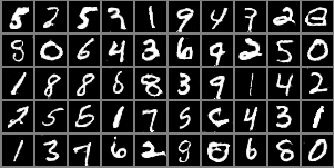

In [12]:
# Generate two random integers to select a random model that is to be used in generating a fake image batch with MarginGAN's generator
lab = np.random.randint(0,4)
ind = np.random.randint(0,5)

all_model_paths = model_paths()
model = all_model_paths[str(label_sizes[lab])][ind]
# Create a model instance
marginGAN = MarginGAN()
# Load the randomly selected model
marginGAN.load(model)
# Show the randomly sampled image
marginGAN.imshow(fixed_noise)

Fig. 3: Reproduction of Figure 3-a from [1]

<br/>

<p><img src="https://raw.githubusercontent.com/sonatbaltaci/marginGAN/master/figures/marginGAN_fig3.png" height=300px></p>

Fig. 4: Figure 3-a from [1]

<br/>

## Challenges Faced

Although the overall idea to utilize the GAN architecture to enhance the semi-supervised learning process was clearly explained, crucial architectural details were missing:

### Dataset
Firstly, since MNIST has no specific validation set, we separate 10000 samples to be used as the validation set for hyperparameter optimization. This was not mentioned in the paper. Additionally, no information provided about the normalization of the data. It is stated in various studies that the normalization of data helps the training process. Thus we normalized training, validation, and test data.

We know that the paper uses 4 different number of labeled examples for their experiments. These are stated to be $100$, $600$, $1000$, and $3000$. However, randomly sampling 100 examples from the training set may cause a class imbalance. Therefore, to create a balanced labeled training set, we choose an equal number of examples from each class. After we divided the dataset into labeled and unlabeled subsets, we observed that there were different techniques in literature to feed the data into the model in semi-supervised learning. In various research, all labeled and unlabeled images are passed into the architecture only once per epoch. On the other hand, since the number of unlabeled images is much higher than the number of labeled images within one iteration, some researchers prefer to iterate the labeled images in a cycle until the unlabeled images are all passed. This choice wasn’t stated in the paper. We experimented with both options and iterating the labels gave better training performance and validation results.

### Model Architecture
Architecture of C was proposed to be a “simple 6-layer” C, but no further detail was given. The number of convolutional and fully-connected layers, the channel and kernel sizes of the layers, and the type of the activation functions were unclear. We first experimented with several architectures having a simple 6-layer structure. However, we observed that increasing the number of layers by adding batch normalization following the convolutional layers improved our pre-training speed and performance (of the main architecture) remarkably. Therefore, we set the architecture of C a little bigger than it is in the paper. 

### Optimizers and Hyperparameters
Most of the hyperparameters and which optimizers were used by the authors were not specified in the paper. Thus, when choosing the hyperparameters and optimizers, we follow common practices used in research, check recent important works on generative models and experiment with different settings and test our results on the validation set.

For the optimizer selection, since InfoGAN [3] and DCGAN [4] uses Adam optimizers for their G and D with $\beta_1$ value of $0.5$ and $\beta_2$ value of $0.999$, we also use Adam optimizer for G and D with these $\beta$ values. For classifiers, it is common practice to use an SGD optimizer. Therefore, we use an SGD optimizer for C. 

Since MarginGAN uses the G and D of the InfoGAN [3], we experimented with the hyperparameter settings in the utilized in InfoGAN [3]. Furthermore, we checked popular generative model papers like DCGAN [4] to find a good range of learning rates for our discriminator and generator. We also investigated general practices used in research and experimented with different settings. For the learning rate value of D, we tried different values and for most cases D was stable. Therefore, we choose $0.0002$ to be the learning rate of D, which was the setting in InfoGAN [3] and DCGAN [4], both. 

Choosing the learning rate for G was trickier. The learning rate used in InfoGAN [3] was $0.001$ but we found that this value was too high and made the training process for G unstable. In addition, the images generated with this learning rate were meaningless. Therefore, after experimenting with lower values, we choose $0.0002$ to be the learning rate of our G.

In the paper, they mention in Chapter 4.2 that they reduce the learning rate of C from $0.1$ to $0.01$ in these experiments. We deduce that in Chapter 4.1 (where we reproduce the results) the paper uses $0.1$ learning rate for C. However, after experimenting with different values of the learning rate and the momentum parameter of SGD optimizer, we found that using a $0.01$ learning rate for C was much more suitable along with a momentum value of $0.8$. Again, there was no mention of the momentum value that the authors used, in the paper.


### Pre-training

In [1], it was stated that the pre-training procedure was performed until C reached the error rates of $8.0\%, 9.3\%, 9.5\%$, and $9.7\%$, respectively for each label size. This seemed illogical because we expect to see better accuracies as the number of labeled examples increase. Also in [5], before including the pseudo-labels, the Drop-NN model is pre-trained with the same numbers of labeled data ($100, 600, 1000, 3000$), and obtained $78\%$, $91.5\%$, $93.5\%$, and $96.5\%$ accuracy respectively. This is a contradiction and we believe this is a mistake on [1]’s side. Therefore, we interpret the error rates in [1] similar to [5] and use $80\%$, $93\%$, $95\%$, and $97\%$ accuracy for each label as to stop the pre-training process.



### References

[1] Dong, Jinhao, and Tong Lin. "MarginGAN: Adversarial Training in Semi-Supervised Learning." Advances in Neural Information Processing Systems. 2019.

[2] Bennett, Kristin P., Ayhan Demiriz, and Richard Maclin. "Exploiting unlabeled data in ensemble methods." Proceedings of the eighth ACM SIGKDD international conference on Knowledge discovery and data mining. 2002.

[3] Chen, Xi, et al. "Infogan: Interpretable representation learning by information maximizing generative adversarial nets." Advances in neural information processing systems. 2016.

[4] Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

[5] Lee, Dong-Hyun. "Pseudo-label: The simple and efficient semi-supervised learning method for deep neural networks." Workshop on challenges in representation learning, ICML. Vol. 3. 2013.
